In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import visdom

import mxnet as mx
from mxnet import gluon
from mxnet import autograd
from mxnet import image

import sys
sys.path.append('../../resuneta/src')
sys.path.append('../../decode/FracTAL_ResUNet/models/semanticsegmentation')
sys.path.append('../../decode/FracTAL_ResUNet/nn/loss')
sys.path.append('../../')
sys.path.append('../MXNet-ResUNeta/')

from bound_dist import get_distance, get_boundary
from FracTAL_ResUNet import FracTAL_ResUNet_cmtsk
from ftnmt_loss import ftnmt_loss_masked
from datasets import *

from sklearn.metrics import matthews_corrcoef

import matplotlib.pyplot as plt
%matplotlib inline

# Scaling up model in Maharashtra: Test case

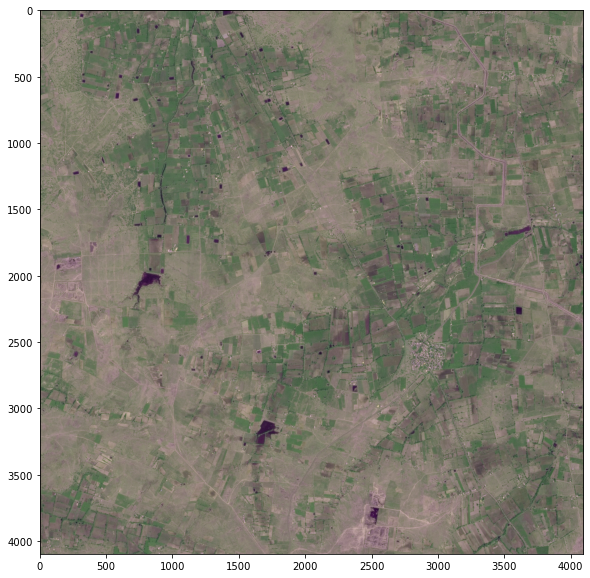

In [3]:
img_4096px = imageio.imread('../data/maharashtra/airbus_false_color_4096px/maharashtra_0000.png')

fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.imshow(img_4096px)
plt.show()

## Break up 4096px image into 256px tiles

In [ ]:
img_dir = '../data/maharashtra/airbus_false_color_4096px/'
save_dir = '../data/maharashtra/airbus_false_color_3x-downsampled_256px/'
img_names = ['maharashtra_{}.png'.format(str(i).zfill(4)) for i in range(10, 3000)]
n_tiles_per_side = 10
n_pixels_per_stride = 256 * 3 // 2
tile_size = 256 * 3

for img_name in img_names:
    img = cv2.imread(os.path.join(img_dir, img_name))
    for i in range(n_tiles_per_side):
        for j in range(n_tiles_per_side):
            x_start = i*n_pixels_per_stride
            y_start = j*n_pixels_per_stride
            if x_start+tile_size > img.shape[0]:
                x_start = img.shape[0] - tile_size
            if y_start+tile_size > img.shape[1]:
                y_start = img.shape[1] - tile_size
            tile = img[x_start:x_start+tile_size, y_start:y_start+tile_size]
            downsized = cv2.resize(tile, (256, 256)) # resize to 256x256
            
            tile_name = img_name[:-4] + '_x{}_y{}.png'.format(str(x_start).zfill(4), str(y_start).zfill(4))
            cv2.imwrite(os.path.join(save_dir, tile_name), downsized)

In [ ]:
img_dir = '../data/maharashtra/airbus_false_color_4096px/'
save_dir = '../data/maharashtra/airbus_false_color_3x-downsampled_256px/'
img_names = ['maharashtra_{}.png'.format(str(i).zfill(4)) for i in range(2000, 3000)]
n_tiles_per_side = 10
n_pixels_per_stride = 256 * 3 // 2
tile_size = 256 * 3

for img_name in img_names:
    img = cv2.imread(os.path.join(img_dir, img_name))
    for i in range(n_tiles_per_side):
        for j in range(n_tiles_per_side):
            x_start = i*n_pixels_per_stride
            y_start = j*n_pixels_per_stride
            if x_start+tile_size > img.shape[0]:
                x_start = img.shape[0] - tile_size
            if y_start+tile_size > img.shape[1]:
                y_start = img.shape[1] - tile_size
            tile = img[x_start:x_start+tile_size, y_start:y_start+tile_size]
            downsized = cv2.resize(tile, (256, 256)) # resize to 256x256
            
            tile_name = img_name[:-4] + '_x{}_y{}.png'.format(str(x_start).zfill(4), str(y_start).zfill(4))
            cv2.imwrite(os.path.join(save_dir, tile_name), downsized)

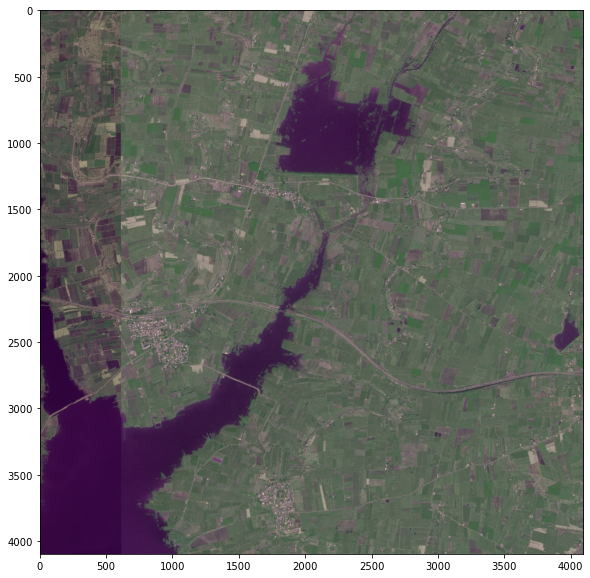

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
img_4096px = imageio.imread('../data/maharashtra/airbus_false_color_4096px/maharashtra_1999.png')
plt.imshow(img_4096px)
plt.show()

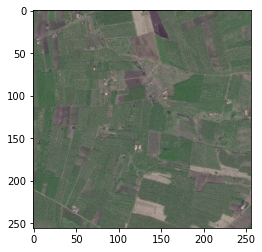

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
img_256px = imageio.imread('../data/maharashtra/airbus_false_color_3x-downsampled_256px/maharashtra_1999_x3328_y3328.png')
plt.imshow(img_256px)
plt.show()

## Dataloaders

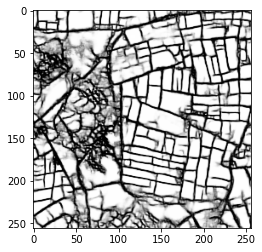

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
extent_256px = imageio.imread('../data/maharashtra/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_finetuned/extent_predictions/maharashtra_0000_x0000_y0000.png')
plt.imshow(extent_256px, cmap='Greys_r')
plt.show()

In [ ]:
base_dir = '../data/maharashtra/'
save_dir = '../data/maharashtra/airbus_false_color_3x-downsampled_256px/'
model_name = 'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_finetuned'
file_name = '../experiments/india/{}/model.params'.format(model_name)
tile_names = [x[:-4] for x in sorted(os.listdir(save_dir)) if 'maharashtra_0' in x]
if not os.path.exists(os.path.join(base_dir, model_name, 'boundary_predictions')):
    os.makedirs(os.path.join(base_dir, model_name, 'boundary_predictions'))
if not os.path.exists(os.path.join(base_dir, model_name, 'extent_predictions')):
    os.makedirs(os.path.join(base_dir, model_name, 'extent_predictions'))

n_filters = 32
depth = 6
n_classes = 1
n_channels = 3
batch_size = 8
codes_to_keep = [1]
boundary_kernel_size = (2,2)
ctx_name = 'gpu'
gpu = 0

if ctx_name == 'cpu':
    ctx = mx.cpu()
elif ctx_name == 'gpu':
    ctx = mx.gpu(gpu)

test_dataset = AirbusNoLabels(
    image_directory=save_dir, image_names=tile_names, image_suffix='.png')
test_dataloader = gluon.data.DataLoader(test_dataset, batch_size=batch_size)

model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, depth=depth, NClasses=n_classes)
model.load_parameters(file_name, ctx=ctx)

for batch_i, img in enumerate(tqdm(test_dataloader, desc='Inference time')):

    img = img.as_in_context(ctx)
    logits, bound, _ = model(img)
    logits = logits.detach().asnumpy()
    bound = bound.detach().asnumpy()

    for i in range(logits.shape[0]):

        # save predictions
        image_id = tile_names[batch_i * batch_size + i]
        bound_uint8 = np.array(bound[i][0] * 255, dtype=np.uint8)
        extent_uint8 = np.array(logits[i][0] * 255, dtype=np.uint8)
        imageio.imwrite(os.path.join(base_dir, model_name, 'boundary_predictions/{}.png'.format(image_id)), bound_uint8)
        imageio.imwrite(os.path.join(base_dir, model_name, 'extent_predictions/{}.png'.format(image_id)), extent_uint8)

depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


Inference time:   1%|          | 127/12500 [01:21<2:10:49,  1.58it/s]

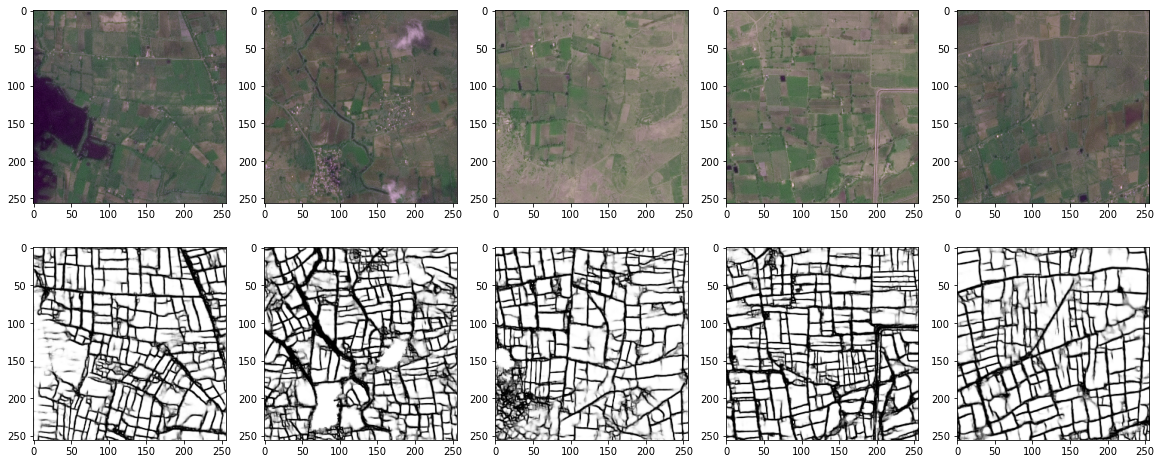

In [17]:
tile_dir = '../data/maharashtra/airbus_false_color_3x-downsampled_256px/'
extent_dir = '../data/maharashtra/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_finetuned/extent_predictions/'
random_imgs = np.random.choice(os.listdir(tile_dir), 5)

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i, img_name in enumerate(random_imgs):
    img = imageio.imread(os.path.join(tile_dir, img_name))
    extent = np.load(os.path.join(extent_dir, img_name[:-4] + '.npy'))
    ax[0, i].imshow(img)
    ax[1, i].imshow(extent, cmap='Greys_r')
plt.show()

## Stitch predictions together

In [27]:
image_ids = ['{}'.format(str(i).zfill(4)) for i in range(10)]
for image_id in image_ids:
    results_dir = '../data/maharashtra/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.001_3x-downsampled-erosion2px_finetuned/'
    extent_dir = os.path.join(results_dir, 'extent_predictions/')
    boundary_dir = os.path.join(results_dir, 'boundary_predictions/')
    pred_names = [x for x in os.listdir(extent_dir) if 'maharashtra_{}'.format(image_id) in x]
    extent_save = os.path.join(results_dir, 'extent_4096px')
    boundary_save = os.path.join(results_dir, 'boundary_4096px')

    img_size = 4096
    extent_pred = np.zeros((img_size, img_size))
    extent_count = np.zeros((img_size, img_size))
    boundary_pred = np.zeros((img_size, img_size))
    boundary_count = np.zeros((img_size, img_size))

    for pred_name in pred_names:
        x = int(pred_name.split('_')[2][1:])
        y = int(pred_name.split('_')[3][1:-4])

        extent_tile = np.load(os.path.join(extent_dir, pred_name))
        extent_tile = cv2.resize(extent_tile, (768, 768))
        extent_pred[x:x+extent_tile.shape[0], y:y+extent_tile.shape[1]] += extent_tile
        extent_count[x:x+extent_tile.shape[0], y:y+extent_tile.shape[1]] += 1

        boundary_tile = np.load(os.path.join(boundary_dir, pred_name))
        boundary_tile = cv2.resize(boundary_tile, (768, 768))
        boundary_pred[x:x+boundary_tile.shape[0], y:y+boundary_tile.shape[1]] += boundary_tile
        boundary_count[x:x+boundary_tile.shape[0], y:y+boundary_tile.shape[1]] += 1

    imageio.imwrite(os.path.join(extent_save, 'maharashtra_{}.png'.format(image_id)), extent_pred/extent_count*255)
    imageio.imwrite(os.path.join(boundary_save, 'maharashtra_{}.png'.format(image_id)), boundary_pred/boundary_count*255)

Lossy conversion from float64 to uint8. Range [3.83124321934325e-06, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.719909444688483e-13, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.9829156741590914e-06, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [6.821510643992225e-17, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.9319216519875226e-05, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [7.098997860957049e-14, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.0284458644704841e-05, 255.0]. Convert image to uint8 prior to saving to suppress this warnin

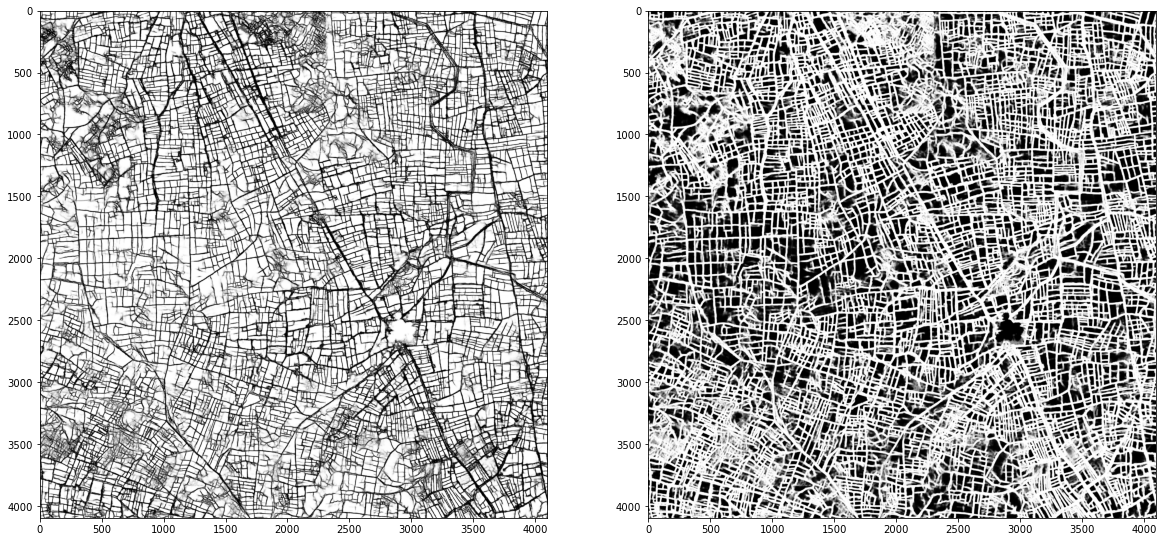

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(extent_pred/extent_count, cmap='Greys_r')
ax[1].imshow(boundary_pred/boundary_count, cmap='Greys_r')
plt.show()

## Watershed segmentation